In [254]:
import numpy as np
from IPython.display import display, clear_output
import time
import itertools
import matplotlib.pyplot as plt

# Elevator environment

We consider a single elevator operated by an agent, for now we also only consider the down peak scenario. This means thats all request or calls are from someone who wants to go from an random floor to the ground floor.

Unlike what is done is the paper, we don't consider the speed of the elevator and slightly modify their modelisation. To model the single elevator problem, one can remark that any successive operations done by the elevator can be expressed in basic "blocks".

Indeed, consider the following blocks :

    - Moving one floor up
    - Moving one floor down
    - Waiting at current floor
    - Taking people in 
    - People exiting
    
Now, each of these actions takes at certain amount of amount which is not necessarily constant (i.e. the last block of "people exiting" takes an amount of time which depend on the number of people exiting and the people themselves). We argue that any observed sequence of actions taken by an elevator can be decomposed using these simple blocks (allowing for multiplication of the first and second actions). If we look at a sequence of actions, the time it will takes should depend in principle on a lot of variables.

Closely following what was done in the referenced paper, with some simplifications we model the actions undertook by the elevator by these 5 blocks. We will also assume that each of these actions (or blocks) takes one unit of time, this is of course not very realistic but this will simplify the implementation. For examples, it allows us to say that if the elevator moves from floor 0 to floor 3 in one go, it is the same (in terms of time consumed) as moving from successively moving from 0 to 1, 1 to 2 and 2 to 3. Furthermore, we force the elevator to take people in if it passes by a floor where there is call.

Finally, an important simplification which is made is in the modelisation of calls. A call happens when someone presses the button at a floor (in our framework the call only means the person wants to go to the ground floor). Calls will be randomly drawn from a discrete distribution, and we will assume that a call counts for 1 person (1 unit of capacity of the elevator) and once the call is made no other call can be made until this person enters the elevator. This is of course a strong assumption. (need to relax this one + change code ,debug) 


We first develop a framework within the assumptions we have stated and then go on to see how we can relax some of theses.


In [630]:
class ELEVATOR():
    """ This object will serve to model a simple elevator and its environment which is the building. 
        To simplify, only one elevator is considered.
        
        
        TODO : be able to monitor waiting times
    """
    def __init__(self, n_floor=4, capacity=4, occupancy=0, floor=0, 
                 call_probas = [0.6875, 0.0625, 0.09375, 0.09375, 0.0625]):
        self.n_floor = n_floor
        self.capacity = capacity
        self.occupancy = occupancy
        self.floor = floor
        self.time = 0
        self.calls = {i : 0 for i in range(0, n_floor + 1)}
        self.call_probas = call_probas
        self.deposited = 0
        
    def update_env(self):
        """ 
        
        """
        if self.floor == 0:
            if self.occupancy > 0:
                self.deposited += self.occupancy
                self.time += 1 #adding a time unit if 
                self.occupancy = 0 #emptying the elevator
        elif self.calls[self.floor]>0 and self.occupancy < self.capacity:
            self.occupancy += 1 #min(self.capacity - self.occupancy, self.calls[self.floor])
            self.calls[self.floor] = 0 #min(self.capacity - self.occupancy, self.calls[self.floor])
            self.time += 1
        
    
    def move(self, direction):
        """ direction : 1 move up, -1 move down, 0 wait
        
        After each move, the time increases by one unit of time.
        """
        self.floor = self.floor + direction
        self.time += 1
        self.update_env()
    
    
    def generate_calls(self):
        """
        
        """
        event = np.random.choice([i for i in range(self.n_floor+1)], p=self.call_probas)
        if event > 0:
            self.calls[event] = 1
    
    def print_current_state(self):
        """ 
        
        """
        clear_output(wait=True)
        for k in range(self.n_floor, -1, -1):
            print("  ======")
            if self.floor == k:
                print("||   E  ||", "*" * self.calls[k])
            else:
                print("||      ||", "*" * self.calls[k])
        print("")
        print("Elevator occupancy :", self.occupancy)
        print("Elevator is on floor :", self.floor)
        print("")
        print("On the schema, the E represent the position of the elevator, * represent calls. Floors ")
        print("are represented between the ====== separations.")

**An example of how the environment evolves if we apply random moves**

In [436]:
ev = ELEVATOR()

In [437]:
for t in range(20):
    if ev.floor == 0:
        next_move = np.random.choice([1, 0])
    elif ev.floor == ev.n_floor:
        next_move = np.random.choice([-1, 0])
    else:
        next_move = np.random.choice([-1, 0, 1])
    ev.generate_calls()
    ev.move(next_move)
    ev.print_current_state()
    time.sleep(0.5)

||      || *
||      || *
||      || *
||   E  || 
||      || 

Elevator occupancy : 0
Elevator is on floor : 1

On the schema, the E represent the position of the elevator, * represent calls. Floors 
are represented between the ====== separations.


## State - Space definition

The state space in this simple model is defined in a 6 dimensional space $\mathbb{X}$. 
Any $x$ in $\mathbb{X}$ can be written as $x = [c_1, c_2, c_3, c_4, p, o]$ where :

    - c_i is equal to 1 iif there if a call on floor i, 0 otherwise. There is no call in floor 0 in our scenario (down peak)
    - p (0,1,2,3,4) indicates the position of the elevator
    - o (0,1,2,3,4) indicates the occupancy of the elevator
    

As detailed earlier we made some simplifications which imply that we don't have the speed variable anymore. So this state space has a cardinality of : $2^4 \cdot 5 \cdot 5 = 400$

## Action Space definition

The agent controls the elevator and can choose his action among 3 possibilities : moving up, down or waiting. We encode these by +1, -1 and 0.

So in each state, the agent choses one of these 3 actions.

## Rewards definition

At time step $t$, the agent finds himself in state $x_t$, we will define the reward as :

$$
r(x_t) = -\sum_{i=1}^{4} c_i - o
$$


So the agent will be penalized by the number of people waiting to reach the ground floor, either because they are waiting in a floor on in the elevator. 

# Q Learning

We first define the mapping from (state, action) to values with all zero values. For now, let us store these values in a dictionnary. It is important to note that the following is computationnaly possible only because the parameters of the problem were chosen so that the State space is small enough (also the motiviation for a simple model provided in the paper).


In [220]:
c_1 = [0, 1] #call in floor 1
c_2 = [0, 1] #call in floor 2
c_3 = [0, 1] #call in floor 3
c_4 = [0, 1] #call in floor 4
p = [0, 1, 2, 3, 4] #position of the elevator
o = [0, 1, 2, 3, 4] #occupancy of the elevator
states = list(itertools.product(c_1, c_2, c_3, c_4, p, o)) #all possible states


In [631]:
#filling the state action values with 0
def init_Q():
    Q = {} #initializing a dictionnary for the state action values
    for s in states:
        for a in [-1, 0, 1]:
            Q[(s, a)] = 0#np.random.randn()*0.002
    return Q

In [639]:
def Q_learning(Q, env, gamma, epsilon, tau, T, eps_anneal, tau_anneal, lr=None, x0 = (0, 0, 0, 0, 0, 0)):
    """ Desc
        --------
        Params :
        
        --------
        Returns :
        
        TODO: add a loop for trials and episode
              Check pb in Q update ?
    """
    xt = x0
    rewards = []
    for t in range(T):
        actions = [-1, 0, 1] #default actions
        #first determine possible actions
        if env.floor == 0 :
            actions = [0, 1]
        if env.floor == env.n_floor :
            actions = [-1, 0] 
        #start epsilon greedy procedure
        u = np.random.random()
        if u >= epsilon: #with proba 1-epsilon this happens
            action_idx = np.argmax([Q[(xt, actions[i])] for i in range(len(actions))]) #greedy choice
            a = actions[action_idx]
            
        else: #with proba epsilon this happens
            #select an action using current Q values and boltzman distribution
            #actions_probas = []
            #for a in actions:
             #   actions_probas.append(np.exp(-Q[(xt, a)]/tau))
            
            #actions_probas = np.array(actions_probas) / np.sum(actions_probas) #normalizing
            a = np.random.choice(actions, 1)[0] #, p=actions_probas)[0]
        
        env.move(a) #realise the chosen action
        r = - env.occupancy - sum(env.calls.values()) #+ env.deposited#compute and observe the reward
        rewards.append(r) #store the reward for monitoring
        x_new = (min(env.calls[0],1), min(env.calls[1],1), min(env.calls[2],1), min(env.calls[3],1), env.floor, env.occupancy) #observe new state
        #----------------
        #Now the reward is observed, update the Q value using Bellman equation
        #----------------
        if not(lr): #if no learning rate was specified
            lr = 1./(t+1) #setting the learning rate s.t. sum is infinite but squared sum is finite
        np.random.shuffle(actions)
        best_future_action = actions[np.argmax([Q[(x_new, actions[i])] for i in range(len(actions))])] #get best future action
        #update Q
        Q[(xt, a)] -= lr * (r + gamma * Q[(x_new, best_future_action)] - Q[(xt, a)])
        #draw calls for time step t
        env.generate_calls()
        xt = x_new #updating the state
        if (t+1)%500 == 0:
            epsilon = epsilon * eps_anneal #annealing epsilon
         
        #tau = tau * tau_anneal #annealing the temperature
    #print(epsilon)
    return rewards

In [640]:
#setting parameters using what was done in the paper
gamma = 0.99
lr = 0.38
epsilon = 0.97
tau = 10
eps_anneal = 0.9
tau_anneal = 0.8
T = 25000 # time steps

In [641]:
env = ELEVATOR()#call_probas = [0.6, 0.05, 0.22, 0.08, 0.05]
Q = init_Q()

In [642]:
rewards = Q_learning(Q, env, gamma, epsilon, tau, T, eps_anneal, tau_anneal, lr, x0 = (0, 0, 0, 0, 0, 0))

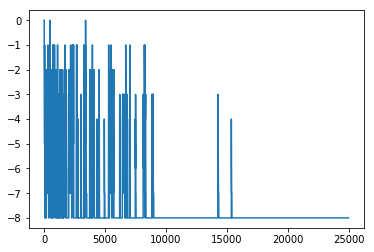

In [643]:
plt.plot(rewards)
plt.show()

In [637]:
Q

{((0, 0, 0, 0, 0, 0), -1): 0,
 ((0, 0, 0, 0, 0, 0), 0): -1118.661797479505,
 ((0, 0, 0, 0, 0, 0), 1): -978.5771335788672,
 ((0, 0, 0, 0, 0, 1), -1): 0,
 ((0, 0, 0, 0, 0, 1), 0): 0,
 ((0, 0, 0, 0, 0, 1), 1): 0,
 ((0, 0, 0, 0, 0, 2), -1): 0,
 ((0, 0, 0, 0, 0, 2), 0): 0,
 ((0, 0, 0, 0, 0, 2), 1): 0,
 ((0, 0, 0, 0, 0, 3), -1): 0,
 ((0, 0, 0, 0, 0, 3), 0): 0,
 ((0, 0, 0, 0, 0, 3), 1): 0,
 ((0, 0, 0, 0, 0, 4), -1): 0,
 ((0, 0, 0, 0, 0, 4), 0): 0,
 ((0, 0, 0, 0, 0, 4), 1): 0,
 ((0, 0, 0, 0, 1, 0), -1): -61.4156,
 ((0, 0, 0, 0, 1, 0), 0): -43.842956,
 ((0, 0, 0, 0, 1, 0), 1): -203.9275454762976,
 ((0, 0, 0, 0, 1, 1), -1): -624.8282431507689,
 ((0, 0, 0, 0, 1, 1), 0): -924.8354734766938,
 ((0, 0, 0, 0, 1, 1), 1): -27.91173298409622,
 ((0, 0, 0, 0, 1, 2), -1): -1481.5375418163885,
 ((0, 0, 0, 0, 1, 2), 0): -79.42,
 ((0, 0, 0, 0, 1, 2), 1): -43.05122746885723,
 ((0, 0, 0, 0, 1, 3), -1): -106.666,
 ((0, 0, 0, 0, 1, 3), 0): -182.32023651215394,
 ((0, 0, 0, 0, 1, 3), 1): -1487.6082838599987,
 ((0, 0

In [621]:
def implement_policy(Q, T, x0=(0,0,0,0,0,0)):
    """ 
    
    """
    ev = ELEVATOR()
    xt = (min(ev.calls[0],1), min(ev.calls[1],1), min(ev.calls[2],1), min(ev.calls[3],1), ev.floor, ev.occupancy)
    for t in range(T):
        ev.print_current_state()
        ev.generate_calls()
        actions = [-1, 0, 1]
        if ev.floor == 0 :
            actions = [0, 1]
        if ev.floor == ev.n_floor :
            actions = [-1, 0]
        np.random.shuffle(actions)
        action_idx = np.argmax([Q[(xt, actions[i])] for i in range(len(actions))]) #greedy choice
        a = actions[action_idx]
        ev.move(a)
        xt = (min(ev.calls[0],1), min(ev.calls[1],1), min(ev.calls[2],1), min(ev.calls[3],1), ev.floor, ev.occupancy) #get new state
        time.sleep(0.5)

In [638]:
implement_policy(Q, 37)

||      || *
||      || *
||      || *
||      || *
||   E  || 

Elevator occupancy : 0
Elevator is on floor : 0

On the schema, the E represent the position of the elevator, * represent calls. Floors 
are represented between the ====== separations.
